In [1]:
import os
os.chdir("..")
import numpy as np
from CPSL_Radar.Analyzer import Analyzer
from CPSL_Radar.datasets.Dataset_Generator import DatasetGenerator
from torchvision import transforms

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#initialize the dataset generator
#campus dataset folders
campus_folder = "/data/david/CPSL_Ground/campus_datasets/"

campus_scenarios = ["scene_{}".format(i+1) for i in range(7)]
campus_test_scenarios = ["scene_{}_test".format(i+1) for i in range(7)]
campus_test_scenarios_spin = ["scene_{}_test_spin".format(i) for i in range(3,5)]

train_scenarios = [os.path.join(campus_folder,scenario_folder) for 
                  scenario_folder in campus_scenarios]

test_scenarios = [os.path.join(campus_folder,scenario_folder) for 
                  scenario_folder in campus_test_scenarios]

test_scenarios_spin = [os.path.join(campus_folder,scenario_folder) for 
                  scenario_folder in campus_test_scenarios_spin]
# wilkenson dataset
# wilkenson_folder = "/data/david/CPSL_Ground/wilkenson_datasets"
# wilkenson_scenarios = ["scene_{}".format(i+1) for i in range(10)]

# wilkenson_test_scenarios = ["scene_{}_test".format(i+1) for i in range(10)]

# train_scenarios.extend([os.path.join(wilkenson_folder,scenario_folder) for
#                    scenario_folder in wilkenson_scenarios])
# test_scenarios.extend([os.path.join(wilkenson_folder,scenario_folder) for
#                    scenario_folder in wilkenson_test_scenarios])

#box_dataset_folders
# box_folder = "/data/david/CPSL_Ground/box_datasets/"

# box_scenarios = ["scene_{}".format(i+1) for i in range(5)]

# train_scenarios.extend(
#     [os.path.join(box_folder,scenario_folder) for
#      scenario_folder in box_scenarios[0:-1]]
# )

# test_scenarios.extend([
#     os.path.join(box_folder,scenario_folder) for 
#     scenario_folder in box_scenarios[-1]])

scenarios_to_use = test_scenarios


#location that we wish to save the dataset to
generated_dataset_path = "/data/david/CPSL_Ground/test/"

#specifying the names for the files
generated_file_name = "frame"
radar_data_folder = "radar"
lidar_data_folder = "lidar"

#basic dataset settings
num_chirps_to_save = 64
num_previous_frames = 0
use_average_range_az = True

#initialize the DatasetGenerator
dataset_generator = DatasetGenerator()

dataset_generator.config_generated_dataset_paths(
    generated_dataset_path=generated_dataset_path,
    generated_file_name=generated_file_name,
    generated_radar_data_folder=radar_data_folder,
    generated_lidar_data_folder=lidar_data_folder,
    clear_existing_data=False
)

#configure the radar data processor
dataset_generator.config_radar_data_processor(
    max_range_bin=64,
    num_chirps_to_save=num_chirps_to_save,
    num_previous_frames=num_previous_frames,
    use_average_range_az= use_average_range_az,
    radar_fov= [-0.87, 0.87], #+/- 50 degrees
    num_angle_bins=64,
    power_range_dB=[60,105],
    chirps_per_frame= 64,
    rx_channels = 4,
    tx_channels = 1,
    samples_per_chirp = 64,
    adc_sample_rate_Hz = 2e6,
    chirp_slope_MHz_us= 35,
    start_freq_Hz=77e9,
    idle_time_us = 100,
    ramp_end_time_us = 100
)

#configure the lidar data processor
dataset_generator.config_lidar_data_processor(
    max_range_m=8.56,
    num_range_bins=64,
    angle_range_rad=[-np.pi/2 - 0.87,-np.pi/2 + 0.87], #[-np.pi /2 , np.pi /2],
    num_angle_bins=48,
    num_previous_frames=num_previous_frames
)

DatasetGenerator._check_for_directory: found directory /data/david/CPSL_Ground/test/
DatasetGenerator._check_for_directory: found directory /data/david/CPSL_Ground/test/radar
DatasetGenerator._check_for_directory: found directory /data/david/CPSL_Ground/test/lidar
max range: 8.5654988m
num actual angle bins: 48


In [3]:
#generate the test dataset if needed
# dataset_generator.generate_dataset()

In [4]:
#initialize the transforms
unet_transforms = [
    transforms.ToTensor(),
    transforms.Resize((64,48))
]

#initialize the viewer
result_analyzer = Analyzer(
    dataset_generator=dataset_generator,
    transforms_to_apply= unet_transforms,
    working_dir="working_dir/",
    model_file_name="averaging.pth",
    cuda_device="cuda:0"
)

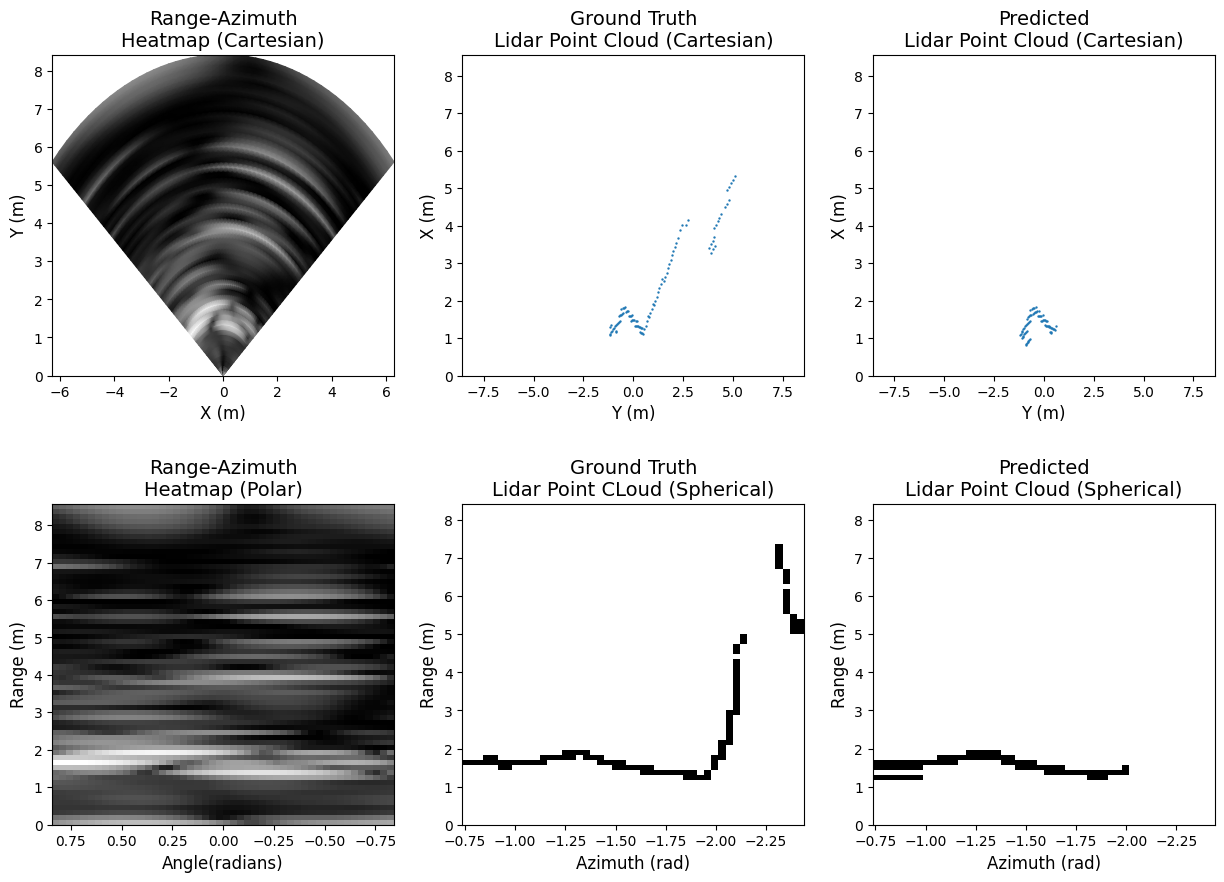

In [8]:
#show the results for a given sample
result_analyzer.view_result(sample_idx=1500)

In [6]:
chamfer_distances, hausdorff_distances,chamfer_distances_radarHD, modified_hausdorff_distances_radarHD = result_analyzer.compute_all_distance_metrics()

result_analyzer.show_summary_statistics(chamfer_distances,hausdorff_distances,chamfer_distances_radarHD, modified_hausdorff_distances_radarHD)

Analyzer.compute_all_distance_metrics: Computing distance metrics


100%|██████████| 10698/10698 [03:05<00:00, 57.68it/s] 

Analyzer.compute_all_distance_metrics: number failed predictoins 50 of 10698 (0.004673770798280052%)


,Metric,Hausdorff,Chamfer,Chamfer (RadarHD),Modified Hausdorff (RadarHD)
0,Mean,2.446866,1.522802,0.329038,0.270165
1,Median,2.138156,0.470629,0.227265,0.133750
2,90th percentile,5.082500,4.193529,0.747129,0.633582


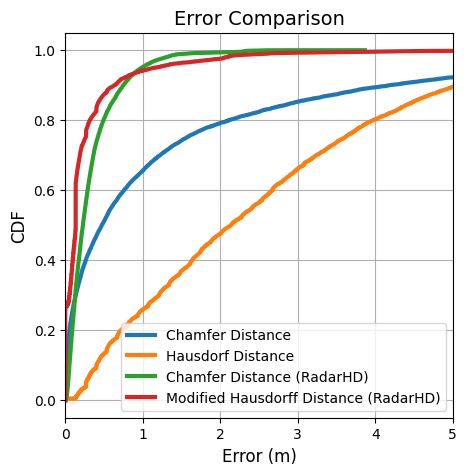

In [7]:
result_analyzer.plot_distance_metrics_cdfs(chamfer_distances,hausdorff_distances,chamfer_distances_radarHD,modified_hausdorff_distances_radarHD)